# Libraries

In [1]:
import os

# go up one directory
os.chdir("..")

import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from functions import cosmic_val
from functions.graph_tools import *
from models.aenmf import *
from functions import data_handling as dh
import torch.optim as optim
import torch.nn as nn

np.random.seed(2)
torch.manual_seed(2) 

# Data

In [2]:
data_path = "data/catalogues_Ovary_SBS.tsv"
cosmic_path = "data/COSMIC_v3.4_SBS_GRCh37.txt"
output_folder = "data/processed"
output_filename = "Ordered_Ovary_SBS.csv"
ordered_data_path = os.path.join(output_folder, output_filename)

In [3]:
dh.load_preprocess_data(data_path, cosmic_path, sep1 = "\t", sep2 = "\t", output_folder = output_folder, output_filename = output_filename)

Data already exists in  data/processed/Ordered_Ovary_SBS.csv


In [4]:
# load data
data = pd.read_csv(ordered_data_path, index_col = 0)
cosmic = pd.read_csv(cosmic_path, sep = "\t", index_col = 0)

In [5]:
LATENT_DIM = 4
TOLERANCE = 1e-10
MAX_ITERATIONS = 100_000_000

In [6]:
losses_train = []
losses_test = []
signatures = []
iterations = 30

for i in tqdm(range(iterations)):
    # Train-test split (here it makes sense, we are working with AE)
    train, test = train_test_split(data.T, test_size = 0.2)

    # Initializing AENMF model
    aenmf_model = aenmf(input_dim = train.shape[1],
                              latent_dim = LATENT_DIM)
    

    # Training AENMF
    aenmf_mod,training_loss_aenmf, signatures_aenmf, exposures_aenmf = train_aenmf( 
                                                model = aenmf_model,
                                                training_data = train,
                                                optimizer = optim.Adam(aenmf_model.parameters(), lr=1e-3),
                                                tol = TOLERANCE,
                                                relative_tol = False,
                                                max_iter = MAX_ITERATIONS)
    

    test_model = aenmf(input_dim = test.shape[1],
                              latent_dim = LATENT_DIM)
    
    
    test_model.load_custom_weights(signature = signatures_aenmf)
    test_model.freeze_encoder()

    _, test_loss, _, _ = train_aenmf(model = test_model,
                                    training_data = test,
                                    optimizer = optim.Adam(test_model.parameters(), lr=1e-3),
                                    tol = TOLERANCE,
                                    relative_tol = False,
                                    max_iter = MAX_ITERATIONS)


    
    # Calculating signatures and exposures for NMF
    epsilon = 1e-8
    diagonals_aenmf = signatures_aenmf.sum(axis=0)
    signatures_aenmf = (signatures_aenmf) @ np.diag(1 / (diagonals_aenmf + epsilon))
    # signatures_aenmf = (signatures_aenmf) @ np.diag(1 / diagonals_aenmf)

    losses_test.append(test_loss[-1])
    losses_train.append(training_loss_aenmf[-1])
    signatures.append(signatures_aenmf)



100%|██████████| 30/30 [08:45<00:00, 17.52s/it]


In [7]:
print("Losses train: ", np.mean(losses_train))
print("Losses test: ", np.mean(losses_test))

Losses train:  18631.660481770832
Losses test:  16418.162158203126


In [8]:
all_signatures = np.hstack(signatures)

In [9]:
pam = KMedoids(n_clusters = LATENT_DIM, metric='cosine').fit(all_signatures.T)
labels = pam.labels_
medoid_indices = pam.medoid_indices_
consensus_signatures = all_signatures[:, medoid_indices]

In [10]:
matched_signatures, mean_similarity = cosmic_val.compute_match(consensus_signatures, cosmic, index = 0)

In [11]:
print(matched_signatures.head())
print("\nMean similarity of the matched signatures: ", mean_similarity)

   Extracted_0  True_0  Similarity_0
0            0    SBS5      0.599770
1            1   SBS52      0.783982
2            2  SBS10a      0.922484
3            3   SBS44      0.827577

Mean similarity of the matched signatures:  0.783453308770687


In [12]:
all_matches = cosmic_val.compute_all_matches(all_signatures, cosmic, k = 4)

In [13]:
all_matches

,True_0,Similarity_0,True_1,Similarity_1,True_2,Similarity_2,True_3,Similarity_3,True_4,Similarity_4,...,True_25,Similarity_25,True_26,Similarity_26,True_27,Similarity_27,True_28,Similarity_28,True_29,Similarity_29
0,SBS44,0.848641,SBS10a,0.928964,SBS26,0.795993,SBS52,0.790550,SBS44,0.784287,...,SBS5,0.599770,SBS52,0.790281,SBS10a,0.924202,SBS1,0.925952,SBS10a,0.923110
1,SBS52,0.793389,SBS6,0.931395,SBS6,0.940603,SBS5,0.602784,SBS5,0.590065,...,SBS52,0.787112,SBS10a,0.922484,SBS15,0.600353,SBS3,0.870009,SBS5,0.603859
2,SBS15,0.624388,SBS12,0.826846,SBS13,0.751812,SBS44,0.835677,SBS52,0.788274,...,SBS10a,0.923733,SBS5,0.599585,SBS52,0.790157,SBS44,0.830661,SBS52,0.788667
3,SBS10a,0.924398,SBS13,0.773836,SBS10a,0.928666,SBS10a,0.922441,SBS10a,0.923349,...,SBS44,0.827577,SBS44,0.818029,SBS44,0.826824,SBS13,0.776612,SBS44,0.838964


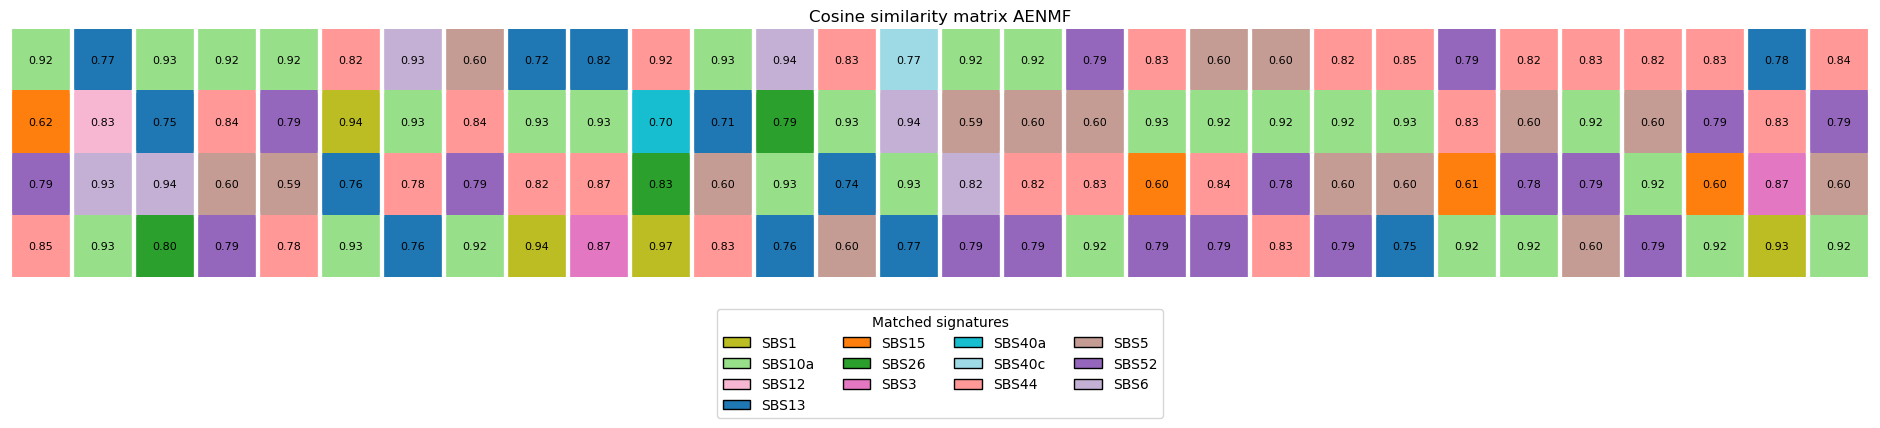

In [14]:
plot_cosine_similarity_matrix(all_matches, title = "Cosine similarity matrix AENMF", figsize=(24, 12), legend_colums=4, palette='tab20')

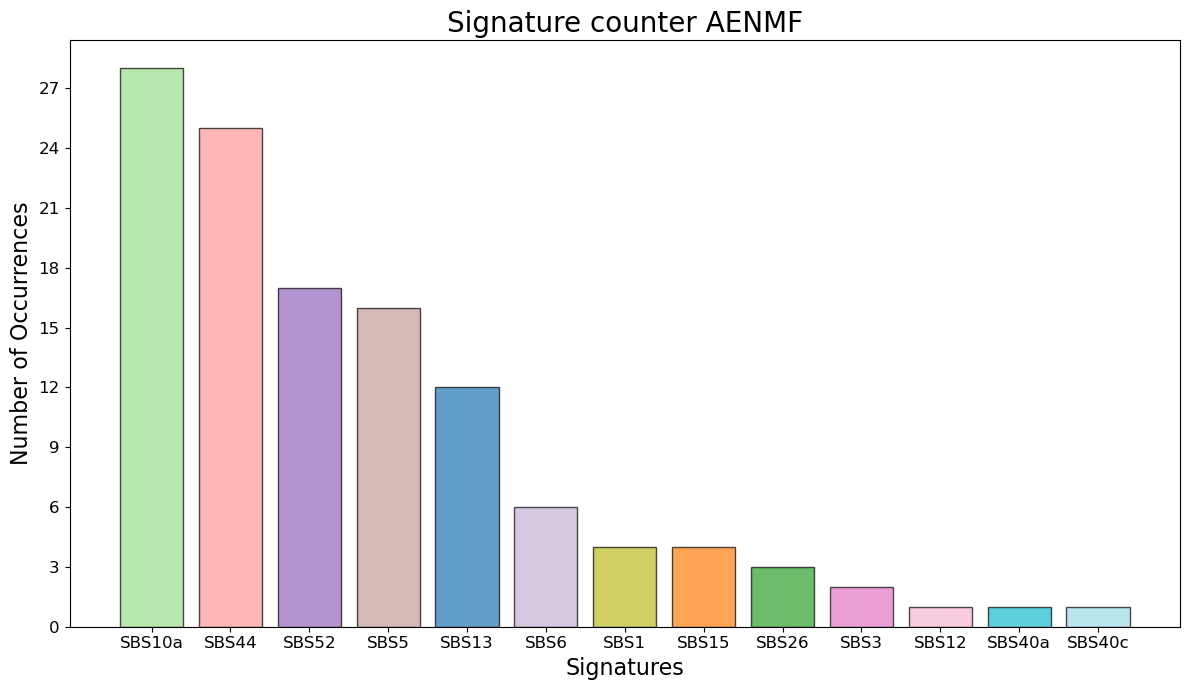

In [15]:
plot_signature_frequency(all_matches, title = "Signature counter AENMF", figsize=(12,7), color='tab20')

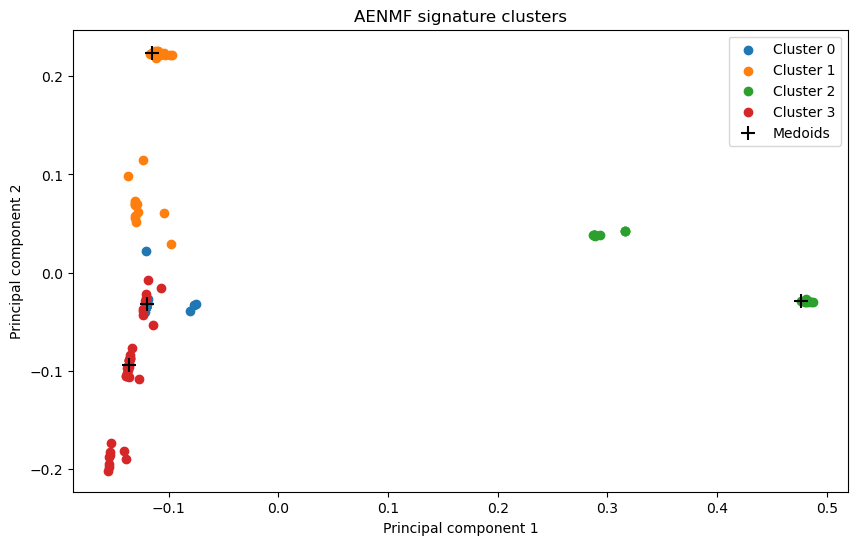

In [16]:
reduced_signatures = PCA(n_components=2).fit_transform(all_signatures.T)
plot_clusters(reduced_signatures, labels, medoid_indices, 4, "AENMF signature clusters")

In [17]:
df_consensus = pd.DataFrame(consensus_signatures, index = data.index)

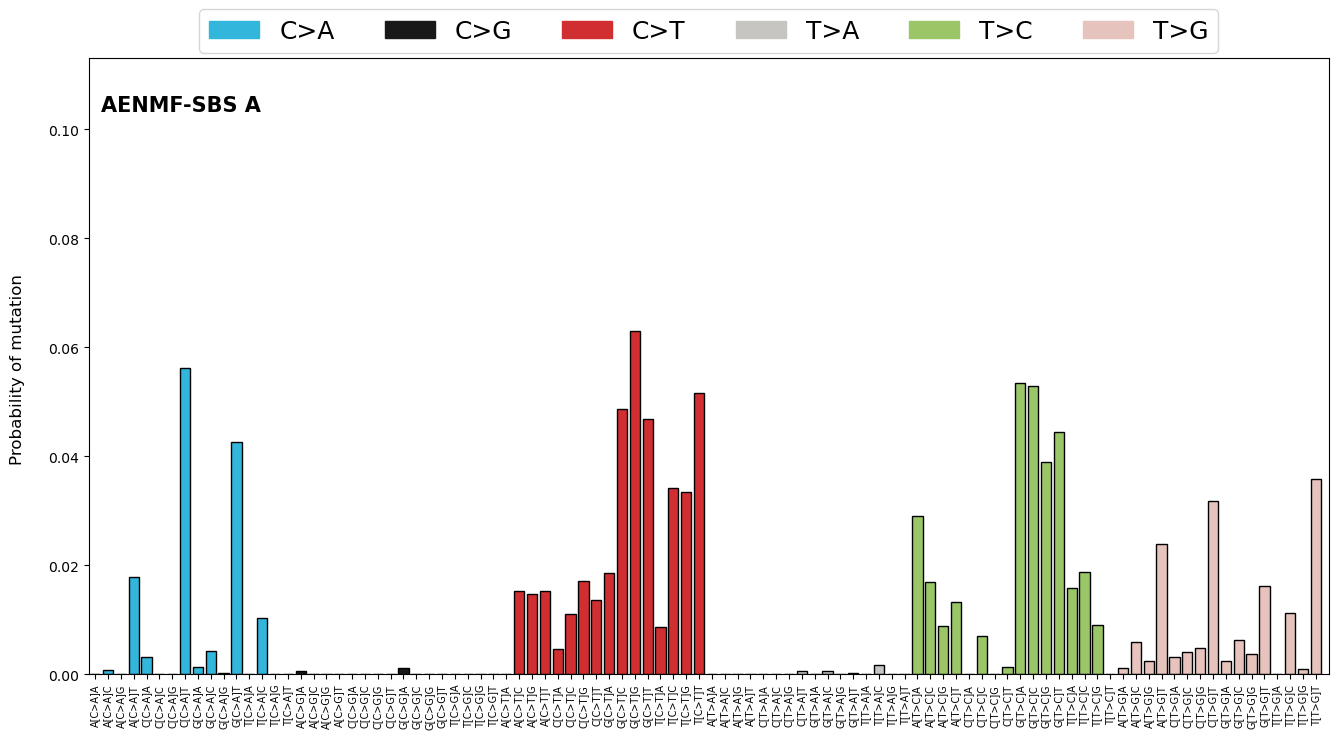

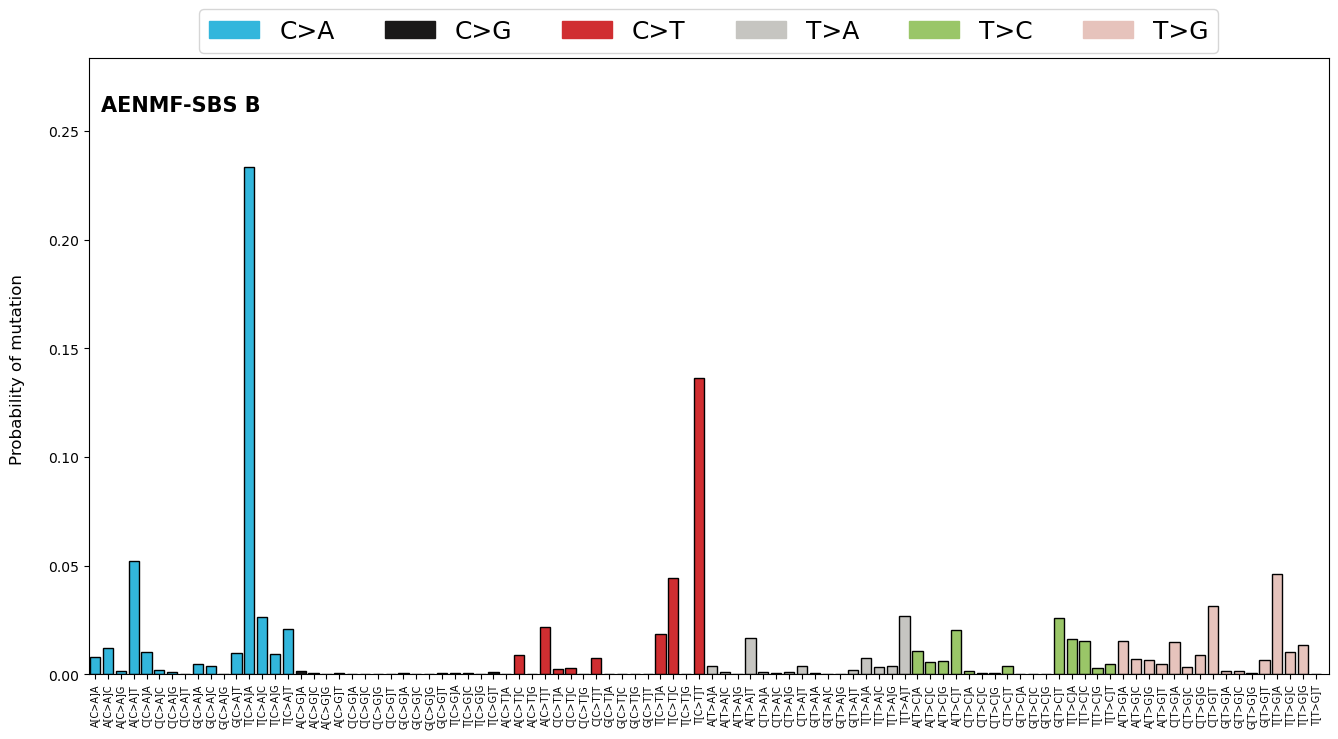

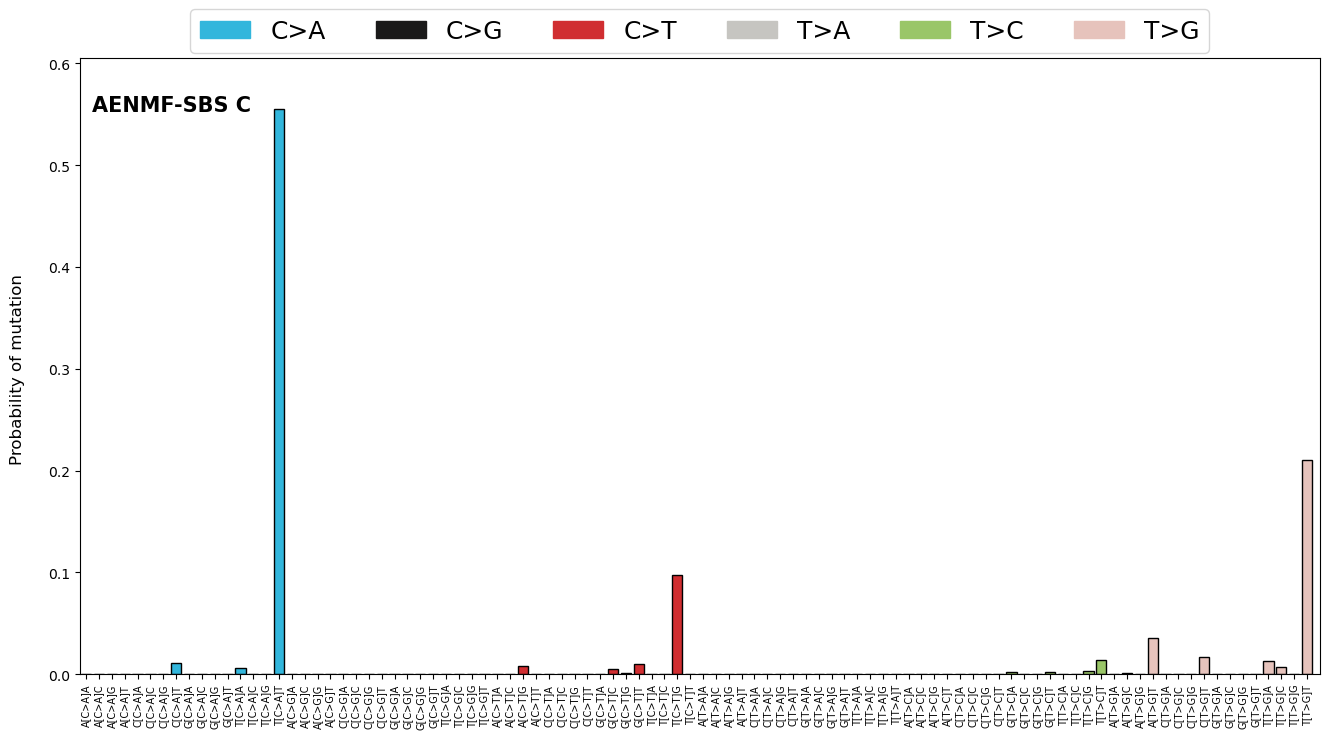

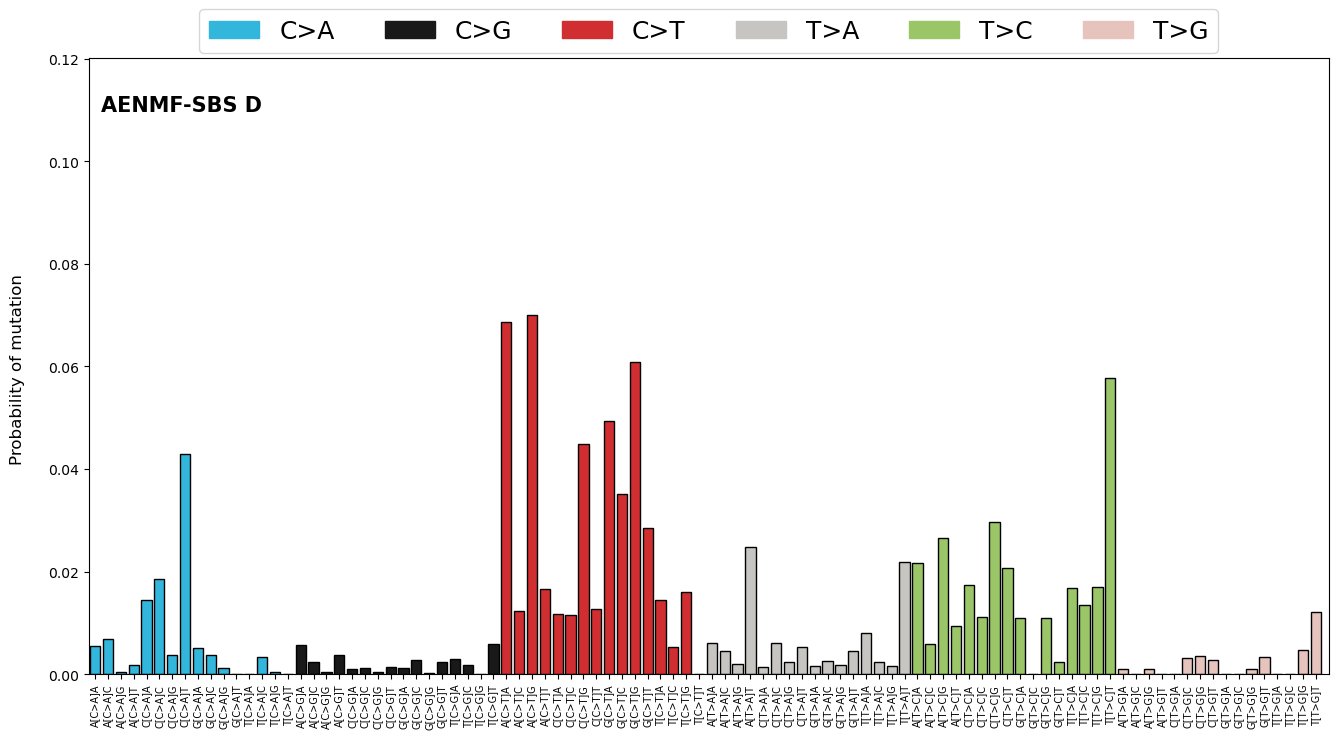

In [18]:
plot_signature(df_consensus, "AENMF")